In [5]:
#import pyLDAvis
#print(pyLDAvis.__version__)
from wordcloud import WordCloud


print(WordCloud)



<class 'wordcloud.wordcloud.WordCloud'>


In [10]:
import warnings
warnings.filterwarnings('ignore')

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation as LDA
import numpy as np

import pyLDAvis
#import pyLDAvis.sklearn

from wordcloud import WordCloud

import seaborn as sns
import matplotlib.pyplot as plt
from itertools import chain

from typing import List, Set, Any


SEED = 123

In [2]:
import nltk

# Baixar os conjuntos de dados necessários
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('rslp')


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Anderson\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Anderson\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.
[nltk_data] Downloading package rslp to
[nltk_data]     C:\Users\Anderson\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping stemmers\rslp.zip.


True

In [4]:
import pandas as pd
from tqdm.auto import tqdm
import nltk
import spacy
from spacy.lang.pt.stop_words import STOP_WORDS
from typing import Set, List

# Carregar o modelo pré-treinado em português 'pt_core_news_lg'
nlp = spacy.load('pt_core_news_lg')

# Função para obter a lista completa de stopwords
def stopwords() -> Set[str]:
    """
    Return complete list of stopwords
    """
    return set(list(nltk.corpus.stopwords.words("portuguese")) + list(STOP_WORDS))

# Obter a lista completa de stopwords
complete_stopwords = stopwords()

# Função para filtrar stopwords e tokens indesejados
def filter(w: spacy.tokens.Token) -> bool:
    """
    Filter stopwords and undesired tokens
    """
    return w.is_alpha and \
           w.text.lower() not in complete_stopwords and \
           w.lemma_ not in ["o", "em", "em o", "em a", "ano"]

# Função para aplicar a lematização do spaCy aos tokens de um texto
def lemma(doc: spacy.tokens.Doc) -> List[str]:
    """
    Apply spacy lemmatization on the tokens of a text

    Returns:
       - a list representing the standardized (with lemmatisation) vocabulary
    """
    return [token.lemma_ for token in doc if filter(token)]

# Função para aplicar o spaCy aos textos e criar a coluna 'spacy_doc'
def process_text(text: str) -> spacy.tokens.Doc:
    """
    Apply spaCy to text and return the Doc object
    """
    return nlp(text)

def NER(doc: spacy.lang.pt.Portuguese) -> List[str]:
    """
    Return the list of organizations for a SPACY document
    """
    # Inicializar uma lista para armazenar as organizações encontradas
    organizations = []
    
    # Iterar sobre as entidades nomeadas no documento
    for ent in doc.ents:
        # Verificar se a entidade é do tipo "ORG" (organização)
        if ent.label_ == "ORG":
            # Adicionar a organização à lista de organizações
            organizations.append(ent.text)
    
    return organizations


class Vectorizer:
    def __init__(self, doc_tokens: List[List[str]], max_features: int = 5000, min_df: int = 10):
        self.doc_tokens = doc_tokens
        self.max_features = max_features
        self.min_df = min_df
        self.tfidf = None

    def vectorizer(self):
        """
        Convert a list of tokens to tfidf vector
        Returns the tfidf vector and attribute it to self.tfidf
        """
        # Inicializar o vetorizador TF-IDF
        tfidf_vectorizer = TfidfVectorizer(max_features=self.max_features, min_df=self.min_df)
        
        # Ajustar e transformar os tokens para obter a representação TF-IDF
        self.tfidf = tfidf_vectorizer.fit_transform([' '.join(tokens) for tokens in self.doc_tokens])

    def __call__(self):
        if self.tfidf is None:
            self.vectorizer()
        return self.tfidf

# Ler o arquivo CSV e criar o DataFrame
df = pd.read_csv("news-of-the-site-folhauol.zip")
df['date'] = pd.to_datetime(df['date'])

# Filtrar notícias de 2016 e da categoria 'mercado'
news_2016 = df[(df['date'].dt.year == 2016) & (df['category'] == 'mercado')]
news_2016.reset_index(drop=True, inplace=True)

# A spaCy aos textos e  coluna 'spacy_doc'
news_2016['spacy_doc'] = tqdm(news_2016['text'].apply(process_text))

#  lematização usando spaCy e coluna 'spacy_lemma'
news_2016['spacy_lemma'] = tqdm(news_2016['spacy_doc'].apply(lemma))

# Aplicar a função NER aos documentos spaCy e  coluna 'spacy_ner'
news_2016['spacy_ner'] = tqdm(news_2016['spacy_doc'].apply(NER))

# Exibir as primeiras linhas do DataFrame resultante
print(news_2016.head())


  0%|          | 0/7943 [00:10<?, ?it/s]

C:\Users\Anderson\AppData\Local\Temp\ipykernel_12948\3008115322.py:72: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  news_2016['spacy_doc'] = tqdm(news_2016['text'].apply(process_text))


  0%|          | 0/7943 [00:00<?, ?it/s]

C:\Users\Anderson\AppData\Local\Temp\ipykernel_12948\3008115322.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  news_2016['spacy_lemma'] = tqdm(news_2016['spacy_doc'].apply(lemma))


  0%|          | 0/7943 [00:00<?, ?it/s]

C:\Users\Anderson\AppData\Local\Temp\ipykernel_12948\3008115322.py:78: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  news_2016['spacy_ner'] = tqdm(news_2016['spacy_doc'].apply(NER))


                                               title  \
0  Fazendeira cria própria rede de banda larga e ...   
1  Alteração na cobrança do ICMS eleva conta de c...   
2  Ajustes sobre servidores públicos emperram nos...   
3  Inventor da internet das coisas ataca mitos so...   
4  Livro analisa empresas de crescimento exponenc...   

                                                text       date category  \
0  "Sou apenas a mulher de um fazendeiro", diz Ch... 2016-12-31  mercado   
1  A conta do celular pós-pago ou controle ficará... 2016-12-31  mercado   
2  A maior parte dos projetos de ajuste das conta... 2016-12-31  mercado   
3  Desde as primeiras décadas do século 19 se diz... 2016-12-31  mercado   
4  O Cifras & Letras seleciona semanalmente lança... 2016-12-31  mercado   

  subcategory                                               link  \
0         NaN  http://www1.folha.uol.com.br/mercado/2016/12/1...   
1         NaN  http://www1.folha.uol.com.br/mercado/2016/12/1...   
2 

  0%|          | 0/7943 [00:08<?, ?it/s]

C:\Users\Anderson\AppData\Local\Temp\ipykernel_5356\3225802996.py:128: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  news_2016['spacy_doc'] = tqdm(news_2016['text'].apply(process_text))


  0%|          | 0/7943 [00:00<?, ?it/s]

C:\Users\Anderson\AppData\Local\Temp\ipykernel_5356\3225802996.py:131: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  news_2016['spacy_lemma'] = tqdm(news_2016['spacy_doc'].apply(lemma))


  0%|          | 0/7943 [00:00<?, ?it/s]

C:\Users\Anderson\AppData\Local\Temp\ipykernel_5356\3225802996.py:134: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  news_2016['spacy_ner'] = tqdm(news_2016['spacy_doc'].apply(NER))
C:\Users\Anderson\AppData\Local\Temp\ipykernel_5356\3225802996.py:144: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  news_2016['tfidf'] = list(vectorizer.transform([' '.join(tokens) for tokens in news_2016['spacy_lemma']]).toarray())
C:\Users\Anderson\AppData\Local\Temp\ipykernel_5356\3225802996.py:156: SettingWithCopyWarning: 


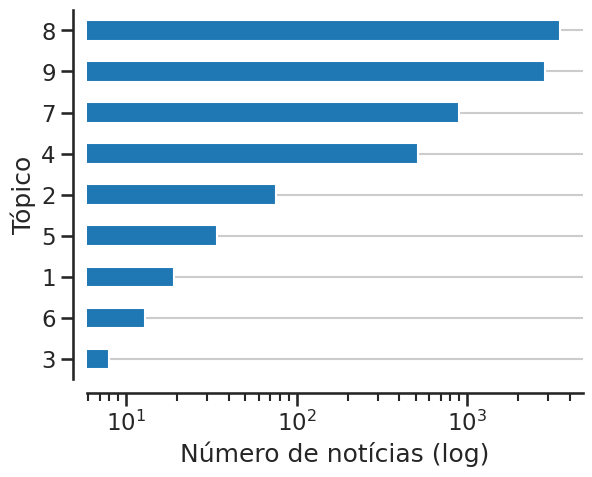

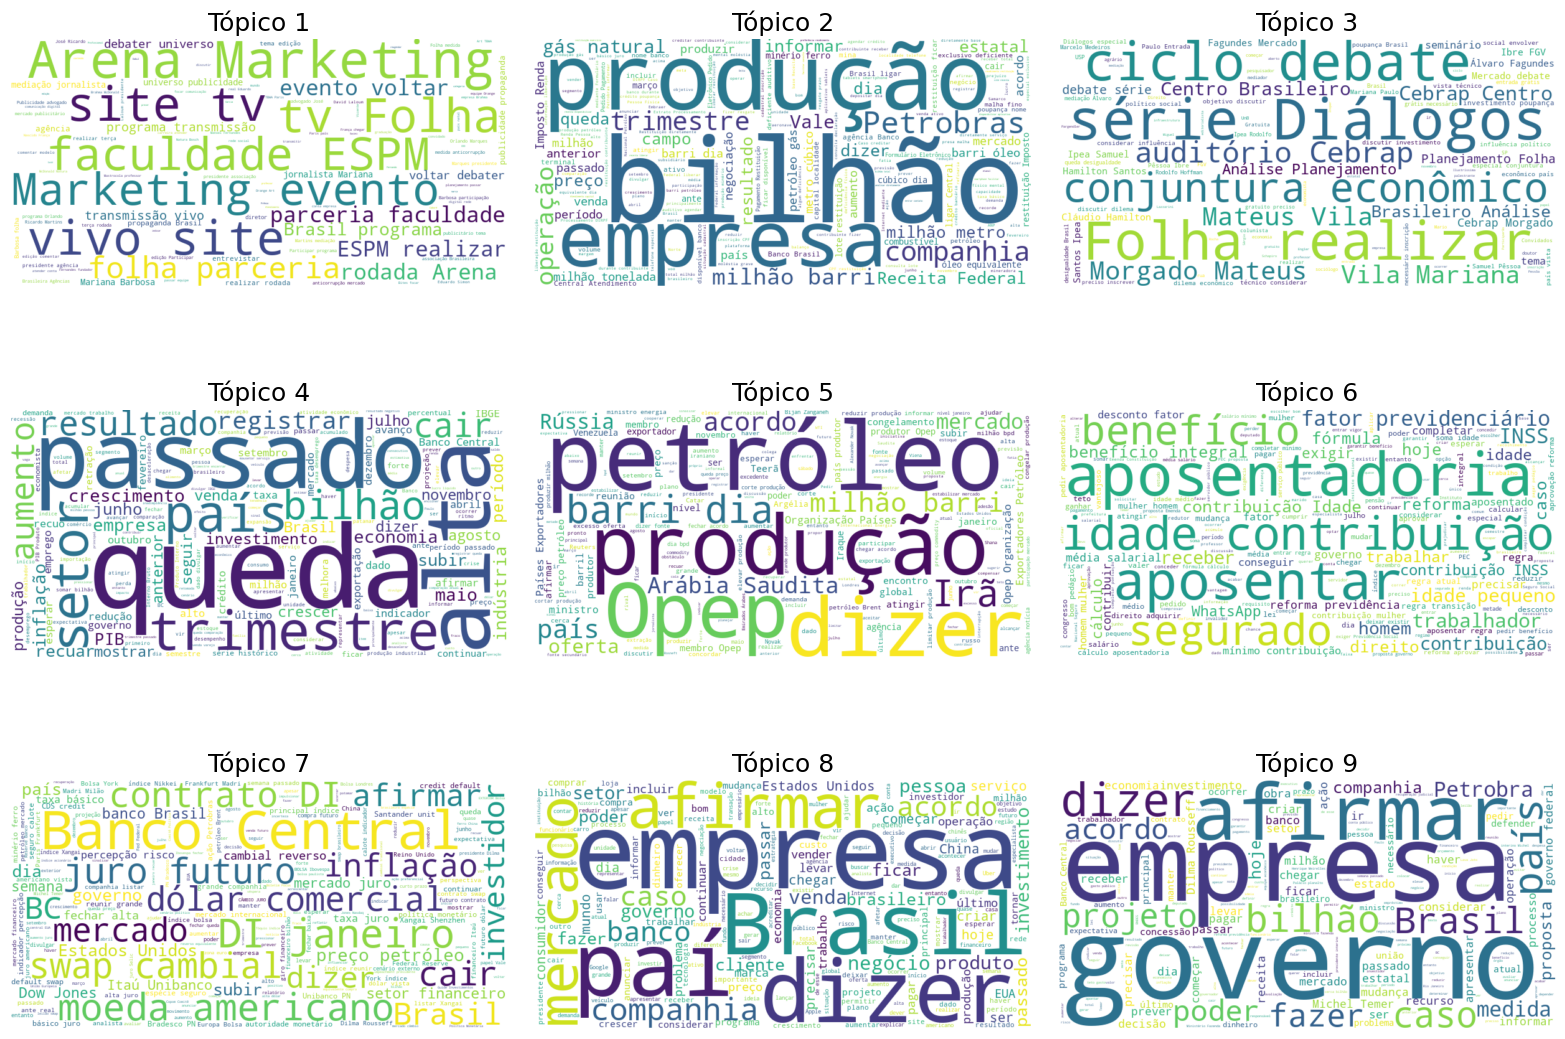

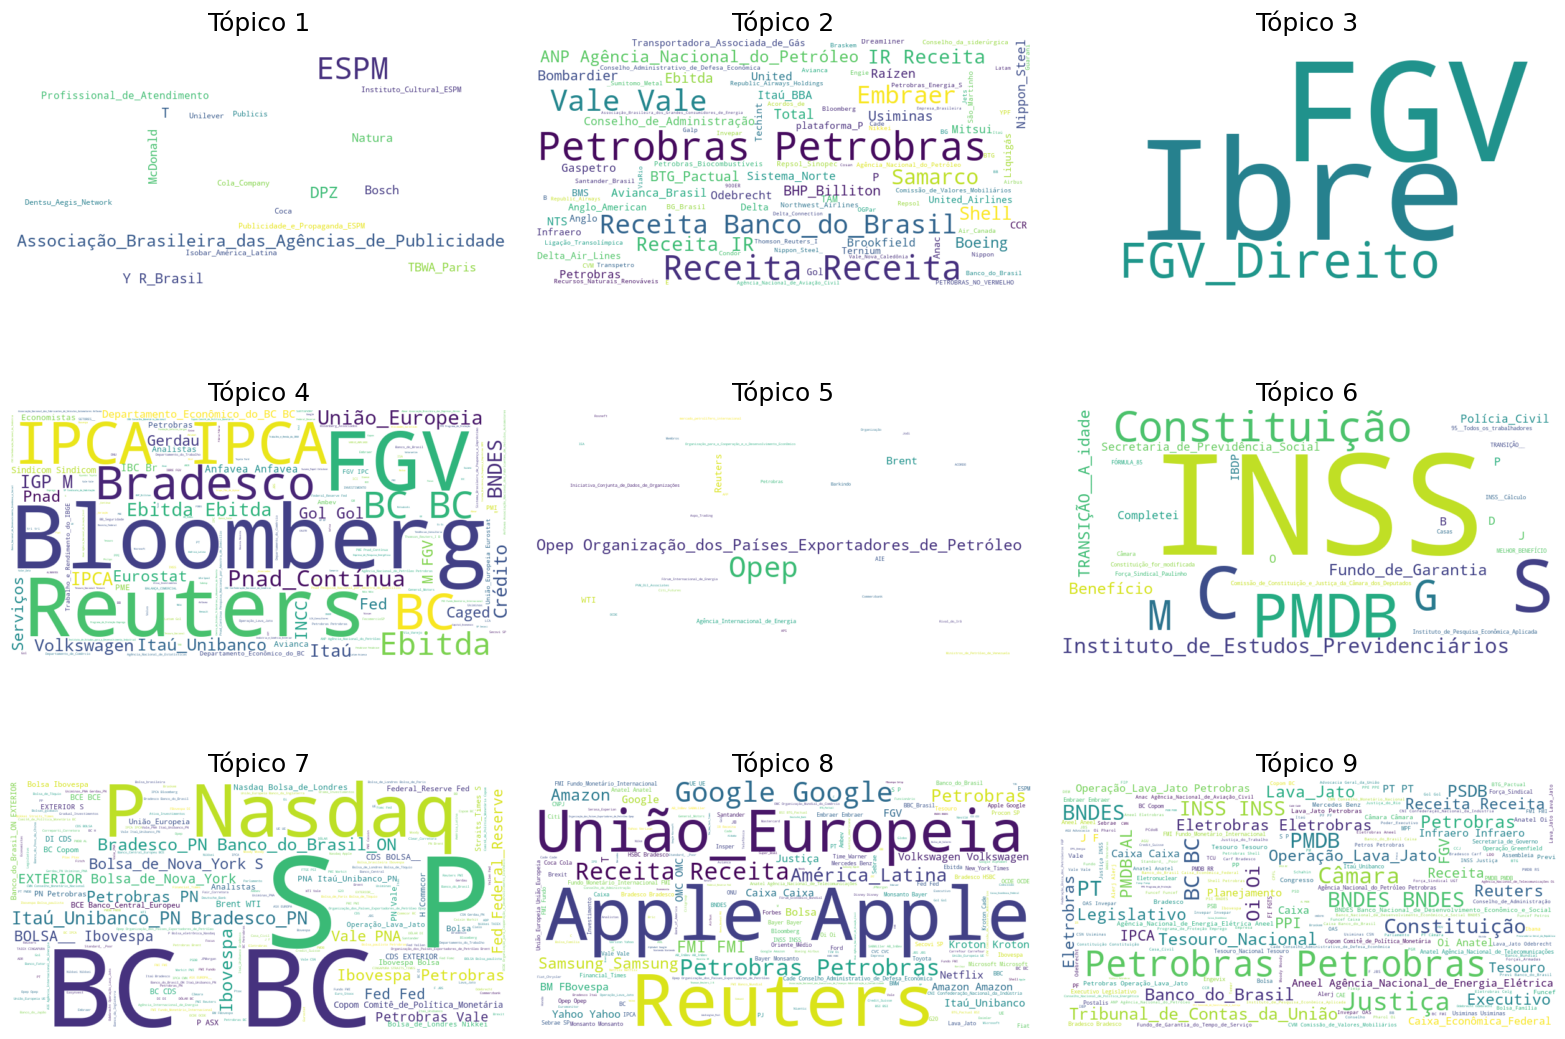

In [7]:
import pandas as pd
import numpy as np
from tqdm.auto import tqdm
import nltk
import spacy
from spacy.lang.pt.stop_words import STOP_WORDS
from typing import Set, List
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import chain
from wordcloud import WordCloud
import pyLDAvis
import pyLDAvis.lda_model


SEED = 42
np.random.seed(SEED)

# Carregar o modelo pré-treinado em português 'pt_core_news_lg'
nlp = spacy.load('pt_core_news_lg')

# Função para obter a lista completa de stopwords
def stopwords() -> Set[str]:
    """
    Return complete list of stopwords
    """
    return set(list(nltk.corpus.stopwords.words("portuguese")) + list(STOP_WORDS))

#  lista completa de stopwords
complete_stopwords = stopwords()

# Função para filtrar stopwords e tokens indesejados
def filter(w: spacy.tokens.Token) -> bool:
    """
    Filter stopwords and undesired tokens
    """
    return w.is_alpha and \
           w.text.lower() not in complete_stopwords and \
           w.lemma_ not in ["o", "em", "em o", "em a", "ano"]

# Função para aplicar a lematização do spaCy aos tokens de um texto
def lemma(doc: spacy.tokens.Doc) -> List[str]:
    """
    Apply spacy lemmatization on the tokens of a text

    Returns:
       - a list representing the standardized (with lemmatisation) vocabulary
    """
    return [token.lemma_ for token in doc if filter(token)]

# Função para aplicar o spaCy aos textos e criar a coluna 'spacy_doc'
def process_text(text: str) -> spacy.tokens.Doc:
    """
    Apply spaCy to text and return the Doc object
    """
    return nlp(text)

def NER(doc: spacy.lang.pt.Portuguese) -> List[str]:
    """
    Return the list of organizations for a SPACY document
    """
   
    organizations = []
    
    # Iterar sobre as entidades nomeadas no documento
    for ent in doc.ents:
        # Verificar se a entidade é do tipo "ORG" (organização)
        if ent.label_ == "ORG":
            # Adicionar a organização à lista de organizações
            organizations.append(ent.text)
    
    return organizations

# Função para converter tokens em vetores TF-IDF
def tokens2tfidf(tokens, vectorizer):
    array = vectorizer.transform([' '.join(tokens)]).toarray()[0]
    return array

# Função para plotar a nuvem de palavras
def plot_wordcloud(text:str, ax:plt.Axes) -> plt.Axes:
    """
    Plot the wordcloud for the text/
    Arguments:
        -  text: string to be analised
        -  ax: plt subaxis
    Returns:
     - ax
    """
    # Plotar a nuvem de palavras
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    ax.imshow(wordcloud, interpolation='bilinear')
    ax.axis('off')
    return ax

#  plotar a nuvem de palavras para um tópico específico
def plot_wordcloud_for_a_topic(topic:int, ax:plt.Axes) -> plt.Axes:
    topic_news = news_2016[news_2016['topic'] == topic]
    list_of_words = chain(*topic_news.spacy_lemma.values.tolist())
    string_complete = ' '.join(list_of_words)
    if not string_complete:
        return None
    return plot_wordcloud(string_complete, ax)

#  plotar a nuvem de entidades para um tópico específico
def plot_wordcloud_entities_for_a_topic(topic:int, ax:plt.Axes) -> plt.Axes:
    topic_news = news_2016[news_2016['topic'] == topic]
    list_of_docs = topic_news.spacy_ner.apply(lambda l : [w.replace(" ", "_") for w in l])
    list_of_words = chain(*list_of_docs)
    string_complete = ' '.join(list_of_words)
    if not len(string_complete):
        return None
    return plot_wordcloud(string_complete, ax)

# Definir o número máximo de tópicos
N_TOPICS = 9

# Ler o arquivo CSV e criar o DataFrame
df = pd.read_csv("news-of-the-site-folhauol.zip")
df['date'] = pd.to_datetime(df['date'])

# Filtrar notícias de 2016 e da categoria 'mercado'
news_2016 = df[(df['date'].dt.year == 2016) & (df['category'] == 'mercado')]
news_2016.reset_index(drop=True, inplace=True)

# Aplicar o spaCy aos textos e criar a coluna 'spacy_doc'
news_2016['spacy_doc'] = tqdm(news_2016['text'].apply(process_text))

# Lematização usando spaCy e coluna 'spacy_lemma'
news_2016['spacy_lemma'] = tqdm(news_2016['spacy_doc'].apply(lemma))

# Aplicar a função NER aos documentos spaCy e criar a coluna 'spacy_ner'
news_2016['spacy_ner'] = tqdm(news_2016['spacy_doc'].apply(NER))

# Obter os tokens de cada documento como uma lista de listas de strings
doc_tokens = news_2016.spacy_lemma.values.tolist()

# Criar uma instância do vetorizador TF-IDF
vectorizer = TfidfVectorizer(max_features=5000, min_df=10)
corpus = vectorizer.fit_transform([' '.join(tokens) for tokens in doc_tokens])

# Atribuir os valores TF-IDF ao dataframe
news_2016['tfidf'] = list(vectorizer.transform([' '.join(tokens) for tokens in news_2016['spacy_lemma']]).toarray())

# Definir o modelo LDA
lda = LatentDirichletAllocation(n_components=N_TOPICS, max_iter=100, random_state=SEED)

# Treinar o modelo LDA
lda.fit(corpus)

# Obter a matriz de tópicos para os documentos
topic_matrix = lda.transform(corpus)

# Atribuir a cada texto um (e apenas um) tópico
news_2016['topic'] = topic_matrix.argmax(axis=1) + 1

# Número de documentos vs tópicos
with sns.axes_style("ticks"):
    sns.set_context("talk")
    ax = news_2016['topic'].value_counts().sort_values().plot(kind='barh')
    ax.yaxis.grid(True)
    ax.set_ylabel("Tópico")
    ax.set_xlabel("Número de notícias (log)")
    sns.despine(offset=10)
    ax.set_xscale("log")

# Criar uma nuvem de palavra para cada tópico
fig, axis = plt.subplots(3, 3, figsize=(16, 12))
axis_ = axis.flatten()
for idx, ax in enumerate(axis_):
    ax_ = plot_wordcloud_for_a_topic(idx + 1, ax)
    if ax_ is None:
        plt.delaxes(ax)
        continue
    ax.set_title(f"Tópico {idx + 1}")
fig.tight_layout()

# Criar uma nuvem de entidades para cada tópico
fig, axis = plt.subplots(3, 3, figsize=(16, 12))
axis_ = axis.flatten()
for idx, ax in enumerate(axis_):
    ax_ = plot_wordcloud_entities_for_a_topic(idx + 1, ax)
    if ax_ is None:
        plt.delaxes(ax)
        continue
    ax.set_title(f"Tópico {idx + 1}")
fig.tight_layout()

# Obter o vocabulário do vetorizador TF-IDF
vocab = vectorizer.get_feature_names_out()

# Calcular a frequência dos termos no corpus
term_frequency = np.asarray(corpus.sum(axis=0)).flatten()

# Visualização dos tópicos usando PyLDAvis
pyLDAvis.enable_notebook()
vis = pyLDAvis.lda_model.prepare(lda, corpus, vectorizer)
pyLDAvis.save_html(vis, 'lda_vis.html')

# Exibir a visualização
pyLDAvis.display(vis)
